In [1]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_sun
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from AntennaUtils import *  

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)

In [2]:
# RT32 location (Ventspils, Latvia)
rt32_antenna = RT32()
rt32_antenna.set_location(latitude=57.5535171694, longitude=21.8545525000, elevation=20)

# Define constants
path = ''
year = 2024
month = 2
day = 15
hour_start = 11
minute_start = 25

observation = SpiralSunObservation(rt32_antenna , year , month , day , hour_start , minute_start)



In [3]:

az_anten, el_anten , az_sun , el_sun , xx1 , yy1, utc = observation.calculatePositions()
observation.generateFile( path, az_anten , el_anten , utc)  



-------------------------------------------------------------
Saved:  sun_scan_240215_1125.ptf    3300   points


True

In [4]:
# Create DataFrame
sunPositionDf = pd.DataFrame({'UTC': utc,'SunX': xx1, 'SunY': yy1})


# Convertir Julian_Time a objetos Time de astropy
time = Time(sunPositionDf['UTC'], format='jd')

# Calcular las horas decimales con precisión de milisegundos para cada valor
decimal_seconds = []

for datetime_obj in time.datetime:
    seconds = time_to_seconds(datetime_obj)
    decimal_seconds.append(seconds)    

# Agregar las horas decimales al DataFrame
sunPositionDf['UTC'] =  np.round(np.array(decimal_seconds).astype(float), 3)

print(sunPositionDf.head())

               UTC         SunX         SunY
0 41100.0000000000 0.0000000000 0.0000000000
1 41101.0000000000 0.0000000000 0.0000000000
2 41102.0000000000 0.0000000000 0.0000000000
3 41103.0000000000 0.0000000000 0.0000000000
4 41104.0000000000 0.0000000000 0.0000000000


In [5]:
fit_file_path = "test2.fit"
hdu_number = 1  # Número de la extensión que contiene la tabla binaria

# Convierte la tabla binaria a un DataFrame de Pandas
data_df = bintable_to_pandas(fit_file_path, hdu_number)

print(data_df.describe())

        LCP 01 4.07GHZ   LCP 04 6.42GHZ   LCP 07 8.40GHZ   LCP 09 9.80GHZ  \
count  1872.0000000000  1872.0000000000  1872.0000000000  1872.0000000000   
mean  17737.5219017094 21194.8723290598 22459.6447649573 22921.1447649573   
std     469.8873997180   305.0346367262   171.8903587763   108.9282116868   
min   17285.0000000000 20890.0000000000 22280.0000000000 22808.0000000000   
25%   17340.0000000000 20929.0000000000 22305.0000000000 22827.0000000000   
50%   17527.5000000000 21060.0000000000 22379.5000000000 22871.0000000000   
75%   18074.0000000000 21475.0000000000 22646.0000000000 23035.0000000000   
max   19696.0000000000 22710.0000000000 23241.0000000000 23863.0000000000   

       LCP 11 11.90GHZ   RCP 01 4.07GHZ   RCP 04 6.42GHZ   RCP 07 8.40GHZ  \
count  1872.0000000000  1872.0000000000  1872.0000000000  1872.0000000000   
mean  15044.6848290598 17459.1901709402 22618.7986111111 21558.5325854701   
std     108.6849335361   517.6658030473   306.4793905360   189.3222038039  

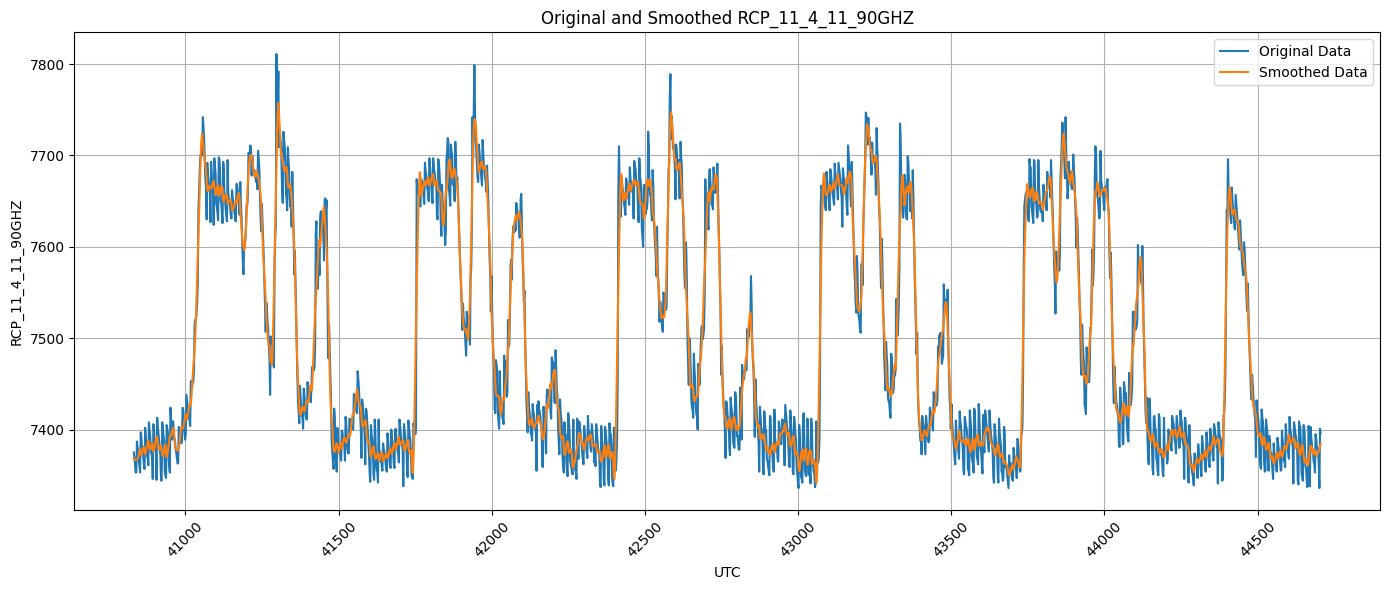

In [6]:
# Extracting columns and dropping NaN values
UTC_RCP_11 = np.round(data_df['UTC RCP 11'].dropna() * 3600, 3)
RCP_11_4_11_90GHZ = data_df['RCP 11 11.90GHZ'].dropna()

# Creating DataFrame with two columns
RCP_11_df = pd.DataFrame({'UTC_RCP_11': UTC_RCP_11.values, 'RCP_11_4_11_90GHZ': RCP_11_4_11_90GHZ.values})

# Applying Savitzky-Golay filter
filtered_RCP_11_4_11_90GHZ = savgol_filter(RCP_11_df['RCP_11_4_11_90GHZ'], window_length=15, polyorder=2)

# Add filtered data as a new column in the DataFrame
RCP_11_df['Filtered_RCP_11_4_11_90GHZ'] = filtered_RCP_11_4_11_90GHZ

# Plotting both original and smoothed data
plt.figure(figsize=(14, 6))
plt.plot(RCP_11_df['UTC_RCP_11'], RCP_11_df['RCP_11_4_11_90GHZ'], label='Original Data', linestyle='-')
plt.plot(RCP_11_df['UTC_RCP_11'], RCP_11_df['Filtered_RCP_11_4_11_90GHZ'], label='Smoothed Data', linestyle='-')
plt.xlabel('UTC')
plt.ylabel('RCP_11_4_11_90GHZ')
plt.title('Original and Smoothed RCP_11_4_11_90GHZ')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Generamos una serie con 999 valores interpolados entre cada par de valores en cada columna
columns = sunPositionDf.columns
interpolated_values = np.empty((sunPositionDf.shape[0] * 1000, sunPositionDf.shape[1]))
for i, col in enumerate(columns):
    for j in range(len(sunPositionDf)-1):
        interpolated_values[j*1000:(j+1)*1000, i] = np.linspace(sunPositionDf.iloc[j][col], sunPositionDf.iloc[j+1][col], 1001)[0:-1]

# Creamos un nuevo DataFrame con los valores interpolados
interpolated_df = pd.DataFrame(interpolated_values, columns=columns)

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)
print(interpolated_df[200:300])

                 UTC         SunX         SunY
200 41100.2000000000 0.0000000000 0.0000000000
201 41100.2010000000 0.0000000000 0.0000000000
202 41100.2020000000 0.0000000000 0.0000000000
203 41100.2030000000 0.0000000000 0.0000000000
204 41100.2040000000 0.0000000000 0.0000000000
..               ...          ...          ...
295 41100.2950000000 0.0000000000 0.0000000000
296 41100.2960000000 0.0000000000 0.0000000000
297 41100.2970000000 0.0000000000 0.0000000000
298 41100.2980000000 0.0000000000 0.0000000000
299 41100.2990000000 0.0000000000 0.0000000000

[100 rows x 3 columns]


In [8]:
print(sunPositionDf.describe())
print(RCP_11_df.describe())

                   UTC            SunX            SunY
count  3300.0000000000 3300.0000000000 3300.0000000000
mean  42749.5000000000   -0.0017625327    0.0038110040
std     952.7722707972   20.6919640052   20.6895363325
min   41100.0000000000  -60.4283809552  -63.9858262570
25%   41924.7500000000   -9.9948465036  -11.6146297392
50%   42749.5000000000    0.0000000000    0.0000000000
75%   43574.2500000000    9.8611902539    9.9619275488
max   44399.0000000000   61.3145328782   52.6190360953
            UTC_RCP_11  RCP_11_4_11_90GHZ  Filtered_RCP_11_4_11_90GHZ
count  1872.0000000000    1872.0000000000             1872.0000000000
mean  42768.5870956197    7498.8311965812             7498.8335392737
std    1119.4295812711     126.2227774824              123.7824761444
min   40831.3420000000    7336.0000000000             7341.6208144797
25%   41799.9437500000    7389.0000000000             7384.7766968326
50%   42768.5405000000    7441.0000000000             7442.8339366516
75%   43737.160

In [9]:
# Realiza la fusión de los DataFrames utilizando diferentes nombres de columna
RCP_11_df['UTC_RCP_11'] = RCP_11_df['UTC_RCP_11'].astype('float64').round(3)
interpolated_df['UTC'] = interpolated_df['UTC'].round(3)
merged_df = pd.merge(interpolated_df, RCP_11_df, left_on='UTC', right_on='UTC_RCP_11')

# Imprime el DataFrame fusionado
print(merged_df.describe())

                   UTC            SunX            SunY       UTC_RCP_11  \
count  1593.0000000000 1593.0000000000 1593.0000000000  1593.0000000000   
mean  42748.9116999372   -0.0008620353    0.0042549306 42748.9116999372   
std     952.6354983691   20.7022750289   20.7023939496   952.6354983691   
min   41100.5470000000  -60.4283656338  -63.9858259877 41100.5470000000   
25%   41924.7210000000   -9.9361260095  -11.6397739186 41924.7210000000   
50%   42748.9040000000    0.0000000000    0.0000000000 42748.9040000000   
75%   43573.0910000000    9.9066904070    9.9998760236 43573.0910000000   
max   44397.2840000000   61.3145263203   52.6190004756 44397.2840000000   

       RCP_11_4_11_90GHZ  Filtered_RCP_11_4_11_90GHZ  
count    1593.0000000000             1593.0000000000  
mean     7507.6629001883             7507.7343025056  
std       126.4402156219              123.8996286888  
min      7336.0000000000             7341.6208144797  
25%      7395.0000000000             7389.1918552

In [10]:
#['t_cal', 't1', 't2', 't3', 't4', 't5','t_slew','t_cal_2','t_slew_2']
num_scan = 5
t_scan_cumsum = np.linspace(0, 4 , 5) * observation.t_scan + t_start_seconds

def filter_dataframe(df, start, end):
    return df[(df['UTC'] >= start) & (df['UTC'] <= end)]


filtered_dfs = {}
cal_df_centre = []
cal_df_sky = []

columns_to_remove = ["UTC","SunX","SunY" , "UTC_RCP_11"]



# Realizar 5 iteraciones
for i, start_seconds in enumerate(t_scan_cumsum):
    
    start_t_cal_1 = start_seconds
    end_t_cal_1 = start_seconds + observation.times_sec_dic['t_cal']

    start_t_slew_1 = start_seconds + observation.times_sec_dic['t5'] 
    end_t_slew_1 = start_seconds + observation.times_sec_dic['t_slew']

    start_t_cal_2 = start_seconds + observation.times_sec_dic['t_slew'] 
    end_t_cal_2 = start_seconds + observation.times_sec_dic['t_cal_2']

    start_t_slew_2 = start_seconds + observation.times_sec_dic['t_cal_2'] 
    end_t_slew_2 = start_seconds + observation.times_sec_dic['t_slew_2']

    # Definir los filtros para cada iteración
    filters = [
        ('filter_it_{}_t_cal_1'.format(i+1), start_t_cal_1, end_t_cal_1),
        ('filter_it_{}_t_slew_2'.format(i+1), start_t_slew_1, end_t_slew_1),
        ('filter_it_{}_t_cal_2'.format(i+1), start_t_cal_2, end_t_cal_2),
        ('filter_it_{}_t_slew_3'.format(i+1), start_t_slew_2, end_t_slew_2)
    ]
    
    # Apply filters and store the filtered dataframes    
    for filter_name, start, end in filters:
        if (filter_name.endswith("t_cal_1")):
            cal_df_centre.append(filter_dataframe(merged_df, start, end).drop(columns=columns_to_remove).mean().values)
        elif (filter_name.endswith("t_cal_2")):
            cal_df_sky.append(filter_dataframe(merged_df, start, end).drop(columns=columns_to_remove).mean().values)
        filtered_dfs[filter_name] = filter_dataframe(merged_df, start, end)


# Combine indices of filtered rows
filtered_indices = set().union(*[filtered_df.index for filtered_df in filtered_dfs.values()])

# Get the rest of the DataFrame excluding the filtered rows
rest_of_df = merged_df[~merged_df.index.isin(filtered_indices)]


# Print the rest of the DataFrame
print(rest_of_df.describe())

NameError: name 't_start_seconds' is not defined

In [ ]:
cal_df_centre = np.array(cal_df_centre)
cal_df_sky = np.array(cal_df_sky)


max_vect = np.mean(cal_df_centre, axis=0)
min_vect = np.mean(cal_df_sky, axis=0)
 

rest_of_df['RCP_11_4_11_90GHZ'] = (rest_of_df['RCP_11_4_11_90GHZ'] - min_vect[0]) / (max_vect[0] - min_vect[0])
rest_of_df['Filtered_RCP_11_4_11_90GHZ'] = (rest_of_df['Filtered_RCP_11_4_11_90GHZ'] - min_vect[1]) / (max_vect[1] - min_vect[1])

# Mostrar el DataFrame resultante
print(rest_of_df.describe())


                   UTC            SunX            SunY       UTC_RCP_11  \
count  1207.0000000000 1207.0000000000 1207.0000000000  1207.0000000000   
mean  42729.3109362055    0.0007213949   -0.0024181763 42729.3109362055   
std     944.9188348102   15.5365717029   15.4934940094   944.9188348102   
min   41160.4980000000  -39.3559052657  -39.6719024686 41160.4980000000   
25%   41944.3675000000  -10.2327127747  -10.1677739887 41944.3675000000   
50%   42730.2970000000    0.0255968612    0.0136946630 42730.2970000000   
75%   43514.1685000000   10.1121099083   10.1018836185 43514.1685000000   
max   44298.0500000000   38.1550737587   38.7912949558 44298.0500000000   

       RCP_11_4_11_90GHZ  Filtered_RCP_11_4_11_90GHZ  
count    1207.0000000000             1207.0000000000  
mean        0.4828501253                0.4823019578  
std         0.4232295069                0.4111654289  
min        -0.1231684982               -0.0680383525  
25%         0.1092032967                0.0874185

C:\Users\2012m\AppData\Local\Temp\ipykernel_18496\4089608109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['RCP_11_4_11_90GHZ'] = (rest_of_df['RCP_11_4_11_90GHZ'] - min_vect[0]) / (max_vect[0] - min_vect[0])
C:\Users\2012m\AppData\Local\Temp\ipykernel_18496\4089608109.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['Filtered_RCP_11_4_11_90GHZ'] = (rest_of_df['Filtered_RCP_11_4_11_90GHZ'] - min_vect[1]) / (max_vect[1] - min_vect[1])


In [ ]:
scaler = MinMaxScaler()
rest_of_df['Filtered_RCP_11_4_11_90GHZ'] = scaler.fit_transform(rest_of_df[['Filtered_RCP_11_4_11_90GHZ']])
rest_of_df['RCP_11_4_11_90GHZ'] = scaler.fit_transform(rest_of_df[['RCP_11_4_11_90GHZ']])

C:\Users\2012m\AppData\Local\Temp\ipykernel_18496\3707798421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['Filtered_RCP_11_4_11_90GHZ'] = scaler.fit_transform(rest_of_df[['Filtered_RCP_11_4_11_90GHZ']])
C:\Users\2012m\AppData\Local\Temp\ipykernel_18496\3707798421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['RCP_11_4_11_90GHZ'] = scaler.fit_transform(rest_of_df[['RCP_11_4_11_90GHZ']])


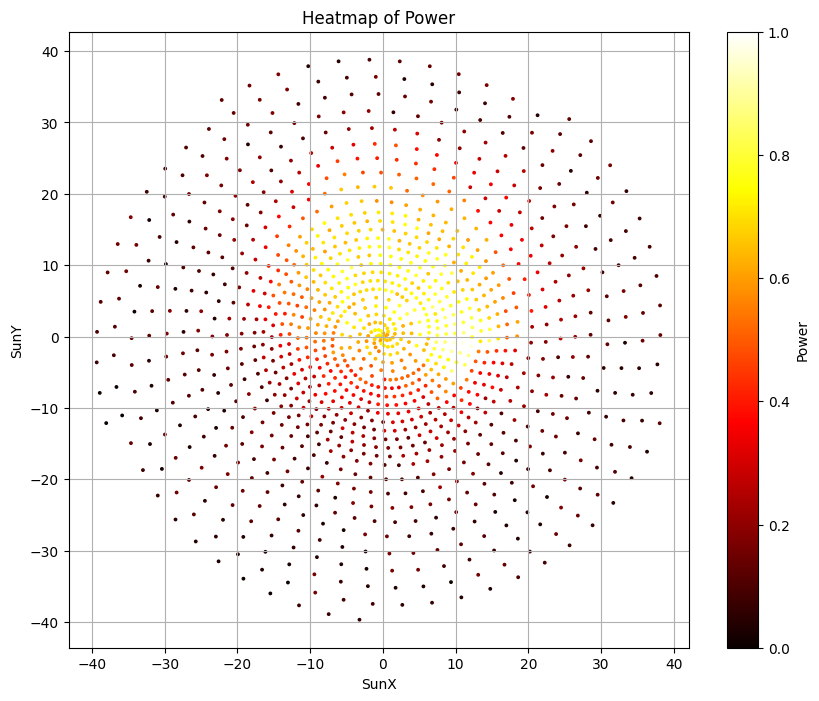

In [ ]:
# Crear el heatmap
plt.figure(figsize=(10, 8))
plt.scatter(rest_of_df['SunX'], rest_of_df['SunY'], c=rest_of_df['RCP_11_4_11_90GHZ'], cmap='hot',s=3)
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap of Power')
plt.grid(True)  # Mostrar la cuadrícula para mayor claridad
plt.show()

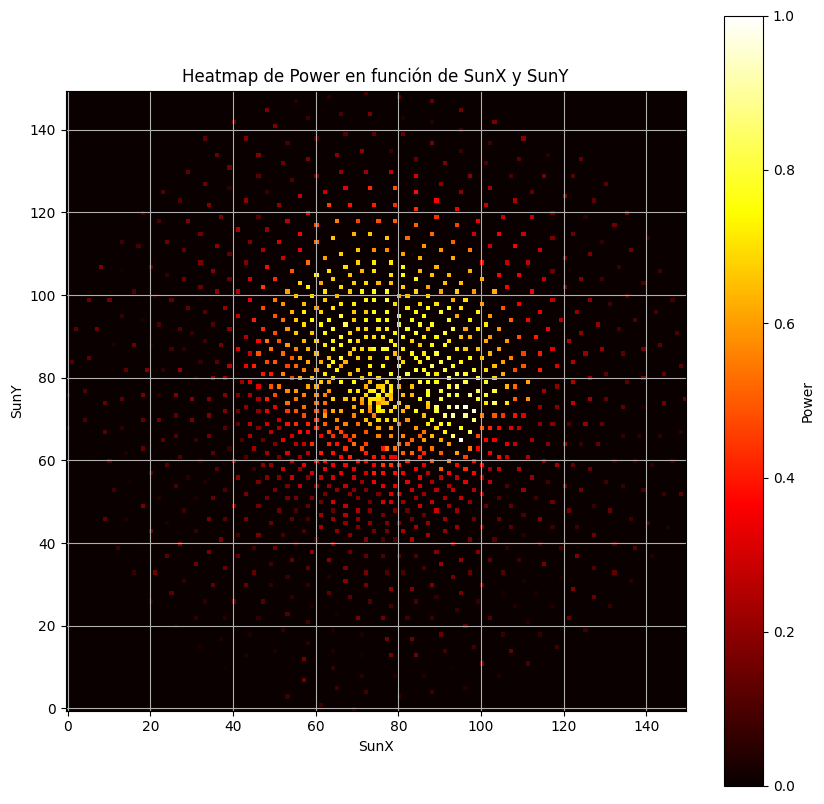

In [ ]:
# Datos de ejemplo
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = rest_of_df['RCP_11_4_11_90GHZ']

# Definir el tamaño de la cuadrícula y crear una matriz de ceros
grid_size = 150
grid_power = np.zeros((grid_size, grid_size))

# Calcular la escala para convertir las coordenadas SunX y SunY en índices de matriz
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Convertir las coordenadas SunX y SunY en índices de matriz
grid_x_index = ((SunX - x_min) / x_range * (grid_size - 1)).astype(int)
grid_y_index = ((SunY - y_min) / y_range * (grid_size - 1)).astype(int)

# Asignar valores de Power a la matriz en las posiciones correspondientes
grid_power[grid_y_index, grid_x_index] = Power

# Mostrar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(grid_power, cmap='hot', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap de Power en función de SunX y SunY')
plt.grid(True)  # Mostrar la cuadrícula para mayor claridad
plt.show()


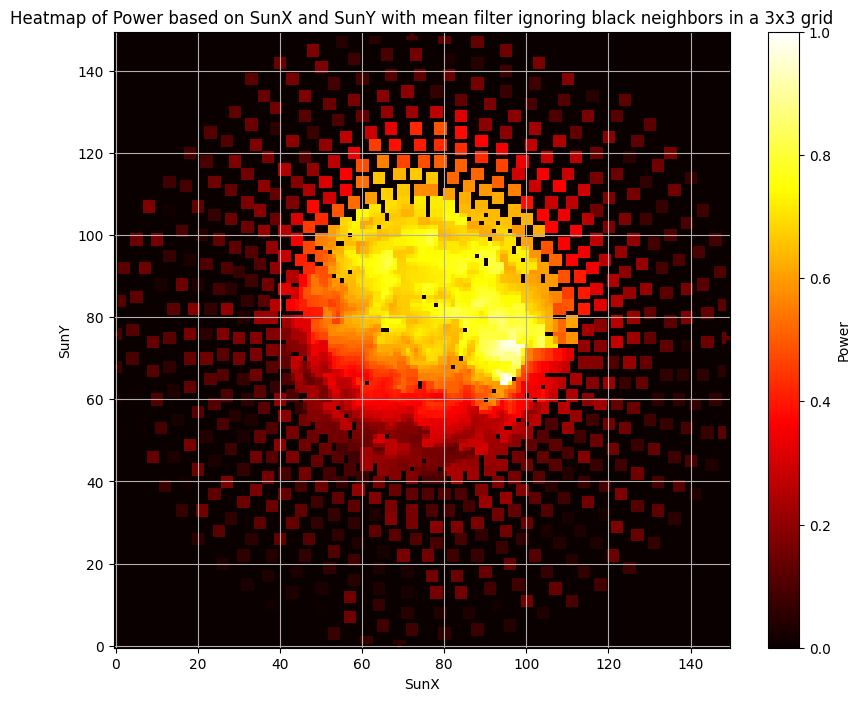

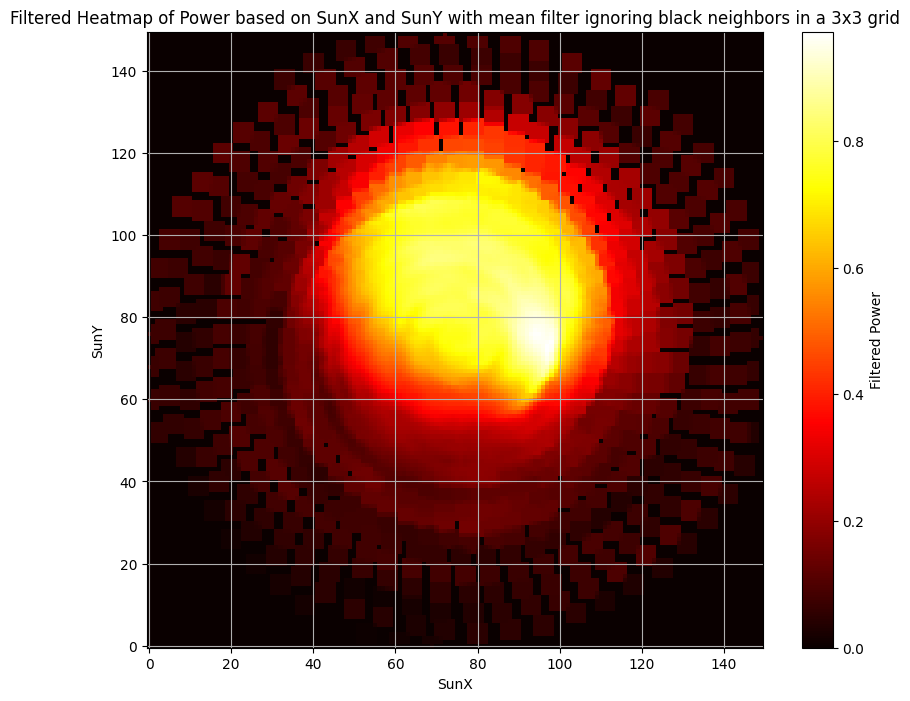

In [ ]:
# Define a function to apply the mean filter ignoring black neighbors in a 3x3 grid
def apply_mean_filter_ignore_black(image):
    y, x = image.shape
    new_image = image.copy()
    for i in range(1, y - 1):
        for j in range(1, x - 1):           
            neighbors = image[i-1:i+2, j-1:j+2]
            non_zero_neighbors = neighbors[neighbors > 0]
            if non_zero_neighbors.size > 0:
                new_image[i, j] = np.mean(non_zero_neighbors)
    return new_image

# Example data
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = rest_of_df['RCP_11_4_11_90GHZ']
PowerFilter = rest_of_df['Filtered_RCP_11_4_11_90GHZ']

# Define the grid size and create a matrix of zeros
grid_size = 150
grid_power = np.zeros((grid_size, grid_size))
grid_power_filter = np.zeros((grid_size, grid_size))

# Calculate the scale to convert SunX and SunY coordinates into matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Convert SunX and SunY coordinates into matrix indices
grid_x_index = ((SunX - x_min) / x_range * (grid_size - 1)).astype(int)
grid_y_index = ((SunY - y_min) / y_range * (grid_size - 1)).astype(int)

# Assign Power values to the matrix at the corresponding positions
grid_power[grid_y_index, grid_x_index] = Power
grid_power_filter[grid_y_index, grid_x_index] = PowerFilter

# Apply mean filter ignoring black neighbors in a 3x3 grid
filtered_image = apply_mean_filter_ignore_black(grid_power)


filtered_image_filter = apply_mean_filter_ignore_black(grid_power_filter)
filtered_image_filter = apply_mean_filter_ignore_black(filtered_image_filter)
# Plot the original image
plt.figure(figsize=(10, 8))
plt.imshow(filtered_image, cmap='hot', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap of Power based on SunX and SunY with mean filter ignoring black neighbors in a 3x3 grid')
plt.grid(True)  # Show grid for clarity
plt.show()

# Plot the filtered image
plt.figure(figsize=(10, 8))
plt.imshow(filtered_image_filter, cmap='hot', origin='lower')
plt.colorbar(label='Filtered Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Filtered Heatmap of Power based on SunX and SunY with mean filter ignoring black neighbors in a 3x3 grid')
plt.grid(True)  # Show grid for clarity
plt.show()
